In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, randint as sp_randint, uniform as sp_uniform
from scipy.cluster import hierarchy

Random state

In [33]:
seed = 42

Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)

In [34]:
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y_true, y_pred):
    ll = log_loss(y_true, y_pred)
    ll_null = log_loss(y_true, np.full(len(y_true), y_true.mean()))
    print(f"ll: {ll}, ll_null: {ll_null}")
    
    # Check for NaN or zero values
    if np.isnan(ll) or np.isnan(ll_null):
        print("Warning: ll or ll_null is NaN.")
        return np.nan
    if ll_null == 0:
        print("Warning: ll_null is zero, which will cause division by zero.")
        return np.nan
    
    # Calculate McFadden's Pseudo R-squared
    r2 = 1 - (ll / ll_null)
    print(f"ll: {ll}, ll_null: {ll_null}, r2: {r2}")
    return r2
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [35]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

Setup folder for storing models

Load the data

In [36]:
df = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'team_id',
         'player_id_wyscout'], axis=1, inplace=True)
X = df.drop('goal', axis=1)
y = df.goal

In [37]:
def check_for_nan(data, data_name):
    nan_count = data.isnull().sum().sum()
    print(f"NaN values in {data_name}: {nan_count}")
    if nan_count > 0:
        nan_columns = data.columns[data.isnull().any()]
        print(f"Columns with NaN values in {data_name}:")
        print(nan_columns)
        print("\nSample rows with NaN values:")
        print(data[nan_columns].head())

check_for_nan(X, "X")
check_for_nan(y, "y")

NaN values in X: 782689
Columns with NaN values in X:
Index(['pass_end_y', 'pass_end_x', 'pass_switch', 'pass_cross',
       'pass_cut_back', 'pass_height_name', 'pass_technique_name',
       'carry_length', 'shot_one_on_one', 'shot_open_goal', 'under_pressure',
       'country_name', 'area_shot', 'area_goal', 'n_angle', 'goalkeeper_x',
       'goalkeeper_y', 'smart_pass'],
      dtype='object')

Sample rows with NaN values:
   pass_end_y  pass_end_x pass_switch pass_cross pass_cut_back  \
0   22.181667   97.208333       False      False         False   
1   46.460000   99.408333       False      False         False   
2         NaN         NaN        None       None          None   
3   34.823500   95.100000       False       True         False   
4         NaN         NaN        None       None          None   

  pass_height_name pass_technique_name  carry_length shot_one_on_one  \
0        High Pass               other           0.0           False   
1        High Pass            

Split into train, calibration and test datasets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed, stratify=y)
# Print the shapes of the resulting datasets
print("\nShapes of the resulting datasets:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
# Check unique values in y_train and y_test
print("\nUnique values in y_train:")
print(y_train.unique())

print("\nUnique values in y_test:")
print(y_test.unique())


Shapes of the resulting datasets:
X_train: (102981, 34)
X_test: (25746, 34)
y_train: (102981,)
y_test: (25746,)

Unique values in y_train:
[False  True]

Unique values in y_test:
[False  True]


In [39]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 1))

Shots train 102981 ;Number goals 10467 ;Goals %:  10.2
Shots test 25746 ;Number goals 2617 ;Goals %:  10.2


Load and split fake data

In [40]:
df_fake = pd.read_parquet(os.path.join('..', 'data', 'fake_shots.parquet'))
df_fake.index = ['a'+str(idx) for idx in df_fake.index]
y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [41]:
print('Shots fake', len(y_fake), ';Goals %: ', round(y_fake.mean()*100, 1))

Shots fake 1000 ;Goals %:  2.1


# Logistic regression

Subset dataset for logistic regression

In [42]:
# drop colum
logistic_drop_cols = ['x', 'y',  # logistic regression does not deal well with dependent features
                      # The model will use the distance/ angle features capture these location features instead
                      # lots of missings for the below features as they come from StatsBomb data only.
                      # It's not fair to impute these as they are not missing at random
                      # while logistic regression does not allow missings so I removed them
                      'pass_end_y', 'pass_end_x',  # <- note these were in Wyscout, but often were just the shot location
                      'eventSec', 'period', 'player_id_goalkeeper',
                      'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal',
                      'under_pressure', 'area_shot', 'area_goal', 'n_angle', 'smart_pass', 'country_name']
X_train_logistic = X_train.drop(logistic_drop_cols, axis=1).copy()
X_test_logistic = X_test.drop(logistic_drop_cols, axis=1).copy()
# Print the shapes of the resulting datasets
print("\nShapes of the resulting datasets for logistic regression:")
print(f"X_train_logistic: {X_train_logistic.shape}")
print(f"X_test_logistic: {X_test_logistic.shape}")


Shapes of the resulting datasets for logistic regression:
X_train_logistic: (102981, 16)
X_test_logistic: (25746, 16)


Split dataset for logistic regession into passes / other assists

In [43]:
def split(X, y):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    y_pass = y[mask]
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    y_other = y[~mask]
    return X_pass, y_pass, X_other, y_other

In [44]:
X_train_pass, y_train_pass, X_train_other, y_train_other = split(X_train_logistic, y_train)
X_test_pass, y_test_pass, X_test_other, y_test_other = split(X_test_logistic, y_test)
check_for_nan(X_train_pass, "X_train_pass")
check_for_nan(y_train_pass, "y_train_pass")
check_for_nan(X_train_other, "X_train_other")
check_for_nan(y_train_other, "y_train_other")
check_for_nan(X_test_pass, "X_test_pass")
check_for_nan(y_test_pass, "y_test_pass")
check_for_nan(X_test_other, "X_test_other")
check_for_nan(y_test_other, "y_test_other")
# Print the shapes of the resulting datasets
print("\nShapes of the resulting datasets after split:")
print(f"X_train_pass: {X_train_pass.shape}")
print(f"y_train_pass: {y_train_pass.shape}")
print(f"X_train_other: {X_train_other.shape}")
print(f"y_train_other: {y_train_other.shape}")
print(f"X_test_pass: {X_test_pass.shape}")
print(f"y_test_pass: {y_test_pass.shape}")
print(f"X_test_other: {X_test_other.shape}")
print(f"y_test_other: {y_test_other.shape}")

NaN values in X_train_pass: 0
NaN values in y_train_pass: 0
NaN values in X_train_other: 0
NaN values in y_train_other: 0
NaN values in X_test_pass: 0
NaN values in y_test_pass: 0
NaN values in X_test_other: 0
NaN values in y_test_other: 0

Shapes of the resulting datasets after split:
X_train_pass: (71962, 15)
y_train_pass: (71962,)
X_train_other: (31019, 11)
y_train_other: (31019,)
X_test_pass: (18043, 15)
y_test_pass: (18043,)
X_test_other: (7703, 11)
y_test_other: (7703,)


Pipeline for cleaning pass assists

In [45]:
cols = ['shot_type_name', 'body_part_name', 'pass_technique_name', 'pass_height_name']
cats = [['open_play', 'free_kick', 'corner', 'throw_in'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging'],
        ['Ground/ Low Pass', 'High Pass']]
pass_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_pass = Pipeline([('one_hot', pass_one_hot),
                      ('impute', SimpleImputer()),
                      ('scale', StandardScaler()),
                      ('lr', LogisticRegression(random_state=seed))])

Column names of transformed pass data

In [46]:
original_cols_remain = [col for col in X_train_pass.columns if col not in cols]
new_cols_pass = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_pass.extend(original_cols_remain)

In [47]:
print(new_cols_pass)
# Check for NaN values in the transformed datasets
print("\nChecking for NaN values in the transformed datasets:")
check_for_nan(X_train_pass, "X_train_pass")
check_for_nan(X_test_pass, "X_test_pass")
check_for_nan(X_train_other, "X_train_other")
check_for_nan(X_test_other, "X_test_other")

['free_kick', 'corner', 'throw_in', 'Left Foot', 'Other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging', 'High Pass', 'counter_attack', 'fast_break', 'strong_foot', 'pass_switch', 'pass_cross', 'pass_cut_back', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal']

Checking for NaN values in the transformed datasets:
NaN values in X_train_pass: 0
NaN values in X_test_pass: 0
NaN values in X_train_other: 0
NaN values in X_test_other: 0


Pipeline for cleaning other assists

In [48]:
# setting direct to recovery so does not not encoded twice ( also covered by shot_type_name == 'direct_set_piece')
X_train_other.loc[X_train_other.assist_type == 'direct', 'assist_type'] = 'recovery'
X_test_other.loc[X_test_other.assist_type == 'direct', 'assist_type'] = 'recovery'

cols = ['shot_type_name', 'body_part_name', 'assist_type']
cats = [['open_play', 'free_kick', 'corner', 'throw_in', 'direct_set_piece'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['recovery', 'clearance', 'rebound']]
other_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_other = Pipeline([('one_hot', other_one_hot),
                       ('impute', SimpleImputer()),
                       ('scale', StandardScaler()),
                       ('lr', LogisticRegression(random_state=seed))])

Column names of transformed passes

In [49]:
original_cols_remain = [col for col in X_train_other.columns if col not in cols]
new_cols_other = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_other.extend(original_cols_remain)

In [50]:
print(new_cols_other)
# Check for NaN values in the transformed datasets for "other" assists
print("\nChecking for NaN values in the transformed datasets for 'other' assists:")
check_for_nan(X_train_other, "X_train_other")
check_for_nan(X_test_other, "X_test_other")

['free_kick', 'corner', 'throw_in', 'direct_set_piece', 'Left Foot', 'Other', 'clearance', 'rebound', 'counter_attack', 'fast_break', 'strong_foot', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal']

Checking for NaN values in the transformed datasets for 'other' assists:
NaN values in X_train_other: 0
NaN values in X_test_other: 0


Search parameters for gridsearchcv

In [51]:
param_grid = {'lr__C': np.logspace(-3, 0.1, 100)}

Fit the inner grid search for shots assisted by passes

In [52]:
clf_pass = GridSearchCV(estimator=pipe_pass, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_pass.fit(X_train_pass, y_train_pass)
print('C:', clf_pass.best_estimator_.named_steps.lr.C)

C: 0.05669377209398


Fit the inner grid search for shots assisted other than passes

In [53]:
clf_other = GridSearchCV(estimator=pipe_other, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_other.fit(X_train_other, y_train_other)
print('C:', clf_other.best_estimator_.named_steps.lr.C)

C: 0.1447458298894319


In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, make_scorer
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, randint as sp_randint, uniform as sp_uniform
from scipy.cluster import hierarchy

seed = 42

def mcfadden_r2(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.clip(np.array(y_pred), 1e-15, 1 - 1e-15)

    ll = log_loss(y_true, y_pred)
    ll_null = log_loss(y_true, np.full(len(y_true), y_true.mean()))

    print(f"ll: {ll}, ll_null: {ll_null}")

    if np.isnan(ll) or np.isnan(ll_null) or ll_null == 0:
        print("Warning: NaN or zero detected in log loss computation.")
        return 0  # Return 0 instead of NaN to avoid breaking cross-validation

    r2 = 1 - (ll / ll_null)
    print(f"McFadden's R²: {r2}")
    return r2


pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)
scoring = {'roc_auc': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

df = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'team_id',
         'player_id_wyscout'], axis=1, inplace=True)
X = df.drop('goal', axis=1)
y = df.goal

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

logistic_drop_cols = ['x', 'y', 'pass_end_y', 'pass_end_x', 'eventSec', 'period', 'player_id_goalkeeper',
                      'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal',
                      'under_pressure', 'area_shot', 'area_goal', 'n_angle', 'smart_pass', 'country_name']
X_train_logistic = X_train.drop(logistic_drop_cols, axis=1).copy()
X_test_logistic = X_test.drop(logistic_drop_cols, axis=1).copy()

def split(X, y):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    y_pass = y[mask]
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    y_other = y[~mask]
    return X_pass, y_pass, X_other, y_other

X_train_pass, y_train_pass, X_train_other, y_train_other = split(X_train_logistic, y_train)
X_test_pass, y_test_pass, X_test_other, y_test_other = split(X_test_logistic, y_test)

cols = ['shot_type_name', 'body_part_name', 'pass_technique_name', 'pass_height_name']
cats = [['open_play', 'free_kick', 'corner', 'throw_in'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging'],
        ['Ground/ Low Pass', 'High Pass']]
pass_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_pass = Pipeline([('one_hot', pass_one_hot),
                      ('impute', SimpleImputer()),
                      ('scale', StandardScaler()),
                      ('lr', LogisticRegression(random_state=seed))])

original_cols_remain = [col for col in X_train_pass.columns if col not in cols]
new_cols_pass = [item for sublist in cats for i, item in enumerate(sublist) if (i > 0)]
new_cols_pass.extend(original_cols_remain)

param_grid = {'lr__C': np.logspace(-3, 0.1, 100)}

clf_pass = GridSearchCV(estimator=pipe_pass, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_pass.fit(X_train_pass, y_train_pass)
print('C:', clf_pass.best_estimator_.named_steps.lr.C)

kf = KFold(n_splits=5, shuffle=True, random_state=seed)
mcfadden_r2_scores = []

for train_idx, val_idx in kf.split(X_train_pass):
    X_train_fold, X_val_fold = X_train_pass.iloc[train_idx], X_train_pass.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_pass.iloc[train_idx], y_train_pass.iloc[val_idx]

    clf_pass.best_estimator_.fit(X_train_fold, y_train_fold)
    y_val_pred_proba = clf_pass.best_estimator_.predict_proba(X_val_fold)[:, 1]

    print("y_true:", y_val_fold.values)
    print("y_pred:", y_val_pred_proba)

    r2_score = mcfadden_r2(y_val_fold, y_val_pred_proba)
    print(f"McFadden's R² for this fold: {r2_score}")

print(f"y_train_pass class distribution: {np.bincount(y_train_pass)}")
print(f"Shapes - X_train_pass: {X_train_pass.shape}, y_train_pass: {y_train_pass.shape}")
nested_score_pass = cross_validate(clf_pass, X=X_train_pass, y=y_train_pass, scoring=scoring, n_jobs=-1)
print("Nested Cross-Validation Scores:", nested_score_pass)
print('ROC AUC for shots assisted by passes:', nested_score_pass['test_roc_auc'].mean())
print("McFadden's Pseudo R-squared shots assisted by passes:", nested_score_pass['test_mcfaddens_r2'].mean())


C: 0.05669377209398
y_true: [False False False ... False False False]
y_pred: [0.14173752 0.08555824 0.05509315 ... 0.02859084 0.02089466 0.08136858]
ll: 0.28940647955496906, ll_null: 0.34033665196209784
McFadden's R²: 0.14964645186907666
McFadden's R² for this fold: 0.14964645186907666
y_true: [False False False ... False False False]
y_pred: [0.04860577 0.0394262  0.14787955 ... 0.07843205 0.07749627 0.160545  ]
ll: 0.27441858909350575, ll_null: 0.32838310680699795
McFadden's R²: 0.1643340250910319
McFadden's R² for this fold: 0.1643340250910319
y_true: [False False False ... False False False]
y_pred: [0.04720352 0.10269737 0.07672166 ... 0.41180455 0.31279494 0.1034889 ]
ll: 0.2768691496236551, ll_null: 0.33096650367661906
McFadden's R²: 0.16345265593953107
McFadden's R² for this fold: 0.16345265593953107
y_true: [False  True False ... False False  True]
y_pred: [0.06429977 0.33632948 0.1033356  ... 0.06218571 0.0881018  0.25475099]
ll: 0.2778237317162529, ll_null: 0.32991092733482

Outer loops for unbiased estimates of the model accuracy

In [54]:
from sklearn.model_selection import cross_val_predict
# Check for NaN values in X_train_pass and y_train_pass
print("\nChecking for NaN values in X_train_pass and y_train_pass:")
check_for_nan(X_train_pass, "X_train_pass")
check_for_nan(y_train_pass, "y_train_pass")

# Perform cross-validation and get predicted probabilities for each fold
y_train_pred_proba_cv = cross_val_predict(clf_pass, X_train_pass, y_train_pass, cv=5, method='predict_proba')[:, 1]
print("Predicted probabilities from cross-validation:")
print(y_train_pred_proba_cv)
# Calculate McFadden's Pseudo R-squared using the true labels and predicted probabilities from cross-validation
mcfadden_r2_cv = mcfadden_r2(y_train_pass, y_train_pred_proba_cv)
# Print McFadden's Pseudo R-squared from cross-validation
print("McFadden's Pseudo R-squared from cross-validation:", mcfadden_r2_cv)

nested_score_pass = cross_validate(clf_pass, X=X_train_pass, y=y_train_pass, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_pass['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared shots assisted by passes:", nested_score_pass['test_mcfaddens_r2'].mean())


Checking for NaN values in X_train_pass and y_train_pass:
NaN values in X_train_pass: 0
NaN values in y_train_pass: 0
Predicted probabilities from cross-validation:
[0.04841356 0.05062723 0.12220029 ... 0.08837639 0.09966429 0.25346773]
ll: 0.27983100152249296, ll_null: 0.33225363702457206
ll: 0.27983100152249296, ll_null: 0.33225363702457206, r2: 0.15777896660978352
McFadden's Pseudo R-squared from cross-validation: 0.15777896660978352
ROC AUC for shots assisted by passes: 0.7824554084320882
McFadden's Pseudo R-squared shots assisted by passes: nan


In [55]:
nested_score_other = cross_validate(clf_other, X=X_train_other, y=y_train_other, scoring=scoring, n_jobs=-1)
print('ROC AUC for other model:', nested_score_other['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for other model:", nested_score_other['test_mcfaddens_r2'].mean())

ROC AUC for other model: 0.7978929747898835
McFadden's Pseudo R-squared for other model: nan


In [56]:
df = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
# Get the predicted probabilities for the training data
y_train_pred_proba = clf_pass.predict_proba(X_train_pass)[:, 1]
# Calculate McFadden's Pseudo R-squared using the true labels and predicted probabilities
mcfadden_r2(y_train_pass, y_train_pred_proba)

# Load the shots data from the Parquet file
df_shots = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
# Load the matches data from the appropriate file (e.g., a CSV or Parquet file)
df_matches = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'match.parquet'))

# Specify the match ID you are interested in
match_id = 3895113

# Filter the matches data to find the row corresponding to the specified match ID
match_details = df_matches[df_matches['match_id'] == match_id]

# Display the details of the specific match
print("\nDetails of the specific match:")
print(match_details)

# If you want to see the shots related to this match, you can filter the shots data
shots_in_match = df_shots[df_shots['match_id'] == match_id]

# Display the shots related to the specific match
print("\nShots related to the specific match:")
print(shots_in_match)
# Create a DataFrame with the true labels and predicted probabilities
df_results = pd.DataFrame({
    'True Label': y_train_pass,
    'Predicted Probability': y_train_pred_proba
})

# Display the DataFrame
print(df_results)

# Specify the index of the shot you are interested in
shot_index = 65007

# Retrieve the row corresponding to the specified index
shot_details = df.loc[shot_index]

# Display the details of the specific shot
print(shot_details)
# Display each column and its value for the specific shot
print("\nEach column and its value for the specific shot:")
for column, value in shot_details.items():
    print(f"{column}: {value}")

ll: 0.27957198544856693, ll_null: 0.33225363702457206
ll: 0.27957198544856693, ll_null: 0.33225363702457206, r2: 0.15855853993889923

Details of the specific match:
    match_id match_date            kick_off  home_score  away_score  \
29   3895113 2023-10-21 2023-10-21 16:30:00           1           2   

   match_status match_status_360               last_updated  \
29    available        available 2023-12-27 04:25:23.928277   

             last_updated_360  match_week  ...  competition_stage_id  \
29 2024-03-27 09:17:41.033608           8  ...                     1   

   competition_stage_name stadium_id      stadium_name stadium_country_id  \
29         Regular Season     4849.0  Volkswagen Arena               85.0   

    stadium_country_name referee_id referee_name referee_country_id  \
29               Germany      236.0  Marco Fritz               85.0   

    referee_country_name  
29               Germany  

[1 rows x 52 columns]

Shots related to the specific match:
       

# LightGBM model

Add fake training data. I am not adding this to the test data as want this to be realistic of real data.

In [57]:
X_train = pd.concat([X_train, X_fake])
y_train = pd.concat([y_train, y_fake])

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [58]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)

    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    # drop some distance/ angle columns
    drop_cols = ['visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle',
                 'log_distance_to_goal', 'eventSec', 'period', 'player_id_goalkeeper', 'country_name']
    df.drop(drop_cols, axis=1, inplace=True)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)

C:\Users\nicol\AppData\Local\Temp\ipykernel_25656\3238328557.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.shot_type_name.replace(shot_type_cat, inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_25656\3238328557.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.shot_type_name.r

In [59]:
print(X_train.columns)

Index(['shot_type_name', 'x', 'y', 'counter_attack', 'fast_break',
       'strong_foot', 'body_part_name', 'assist_type', 'pass_end_y',
       'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
       'pass_height_name', 'pass_technique_name', 'carry_length',
       'shot_one_on_one', 'shot_open_goal', 'under_pressure', 'area_shot',
       'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y', 'smart_pass'],
      dtype='object')


Fit the nested 5-fold cross validation using RandomizedSearchCV optimisation.

In [60]:
#lgbm = LGBMClassifier(random_state=42)
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3)

# Define the parameter grid with the correct prefix
lgbm_param_grid = {
    'estimator__min_child_samples': sp_randint(0, 200),
    'estimator__num_leaves': sp_randint(2, 500),
    'estimator__reg_lambda': sp_uniform(0, 1),
    'estimator__reg_alpha': sp_uniform(0, 1),
    'estimator__max_depth': sp_randint(0, 500)
}

# Initialize RandomizedSearchCV
searchcv = RandomizedSearchCV(estimator=lgbm,
                              n_iter=100,
                              param_distributions=lgbm_param_grid,
                              cv=5,
                              n_jobs=-1)
searchcv.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6992, number of negative: 62328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 69320, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100866 -> initscore=-2.187644
[LightGBM] [Info] Start training from score -2.187644
[LightGBM] [Info] Number of positive: 6992, number of negative: 62329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 69321, number of used features: 25
[LightGBM] [Info] [b

RandomizedSearchCV(cv=5,
                   estimator=CalibratedClassifierCV(cv=3,
                                                    estimator=LGBMClassifier(random_state=42),
                                                    method='isotonic'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CEA7185AF0>,
                                        'estimator__min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CEA51C7080>,
                                        'estimator__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CEA770F440>,
                                        'estimator__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CEA7184560>,
                                        'estimator__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CEA7185400>})

Permutation importance

In [61]:
perm_result = permutation_importance(searchcv.best_estimator_, X_train, y_train, n_repeats=10, random_state=seed)
df_perm_importance = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)

In [62]:
df_perm_importance

,Feature,importance,std_dev
0,x,0.011763,0.000180
1,y,0.010718,0.000263
2,n_angle,0.002275,0.000201
3,goalkeeper_x,0.001635,0.000117
4,area_shot,0.001024,0.000131
5,body_part_name,0.000732,0.000136
6,pass_end_x,0.000705,0.000147
7,goalkeeper_y,0.000664,0.000114
8,shot_type_name,0.000596,0.000134
9,area_goal,0.000588,0.000082


C:\Users\nicol\AppData\Local\Temp\ipykernel_25656\2619739192.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


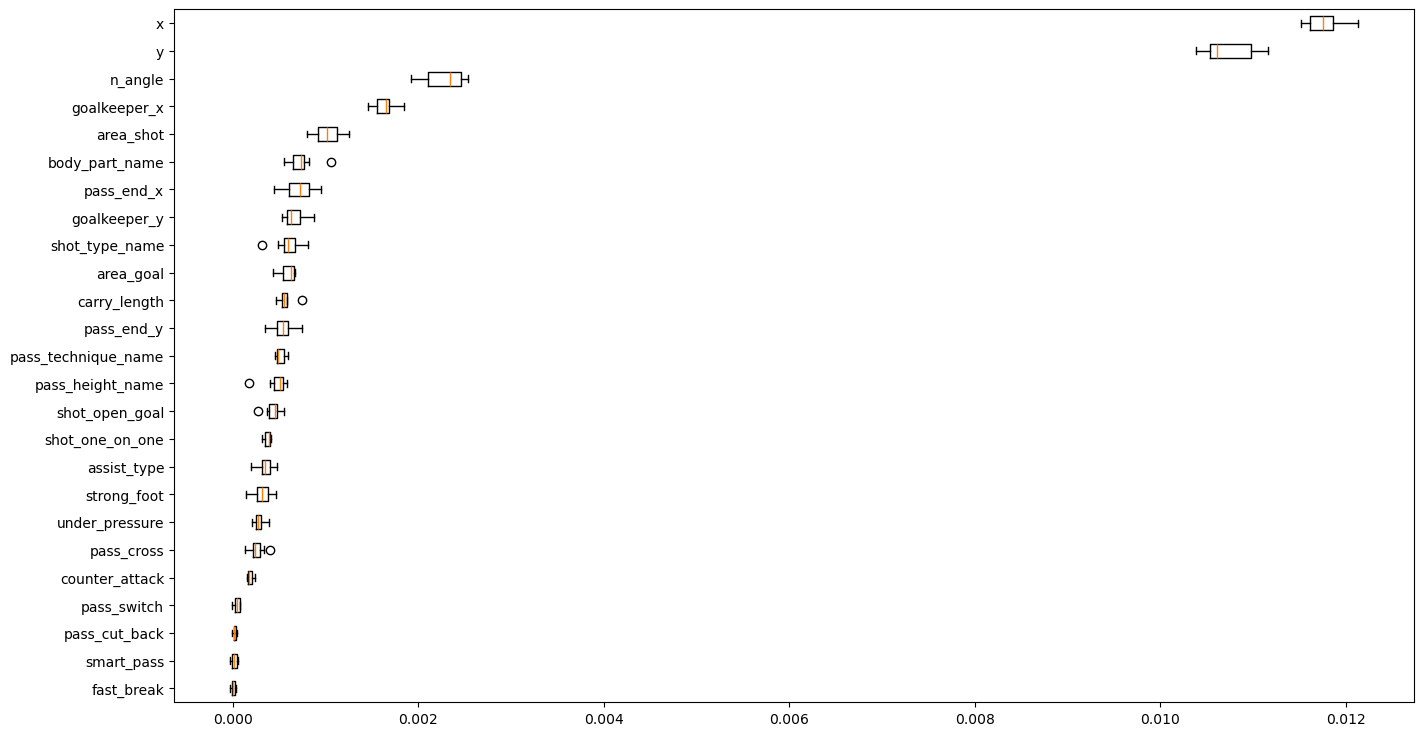

In [63]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

# Test

Calculate calibration curve on test data

In [64]:
y_pred_lgbm_calibrated = searchcv.best_estimator_.predict_proba(X_test)[:, 1]
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test, y_pred_lgbm_calibrated, n_bins=10)
# logistic regression
y_pred_lr_pass = clf_pass.predict_proba(X_test_pass)[:, 1]
y_pred_lr_other = clf_other.predict_proba(X_test_other)[:, 1]
y_pred_lr = np.concatenate([y_pred_lr_pass, y_pred_lr_other])
y_true_test = np.concatenate([y_test_pass, y_test_other])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test, y_pred_lr, n_bins=10)

Plot calibration curve on test data

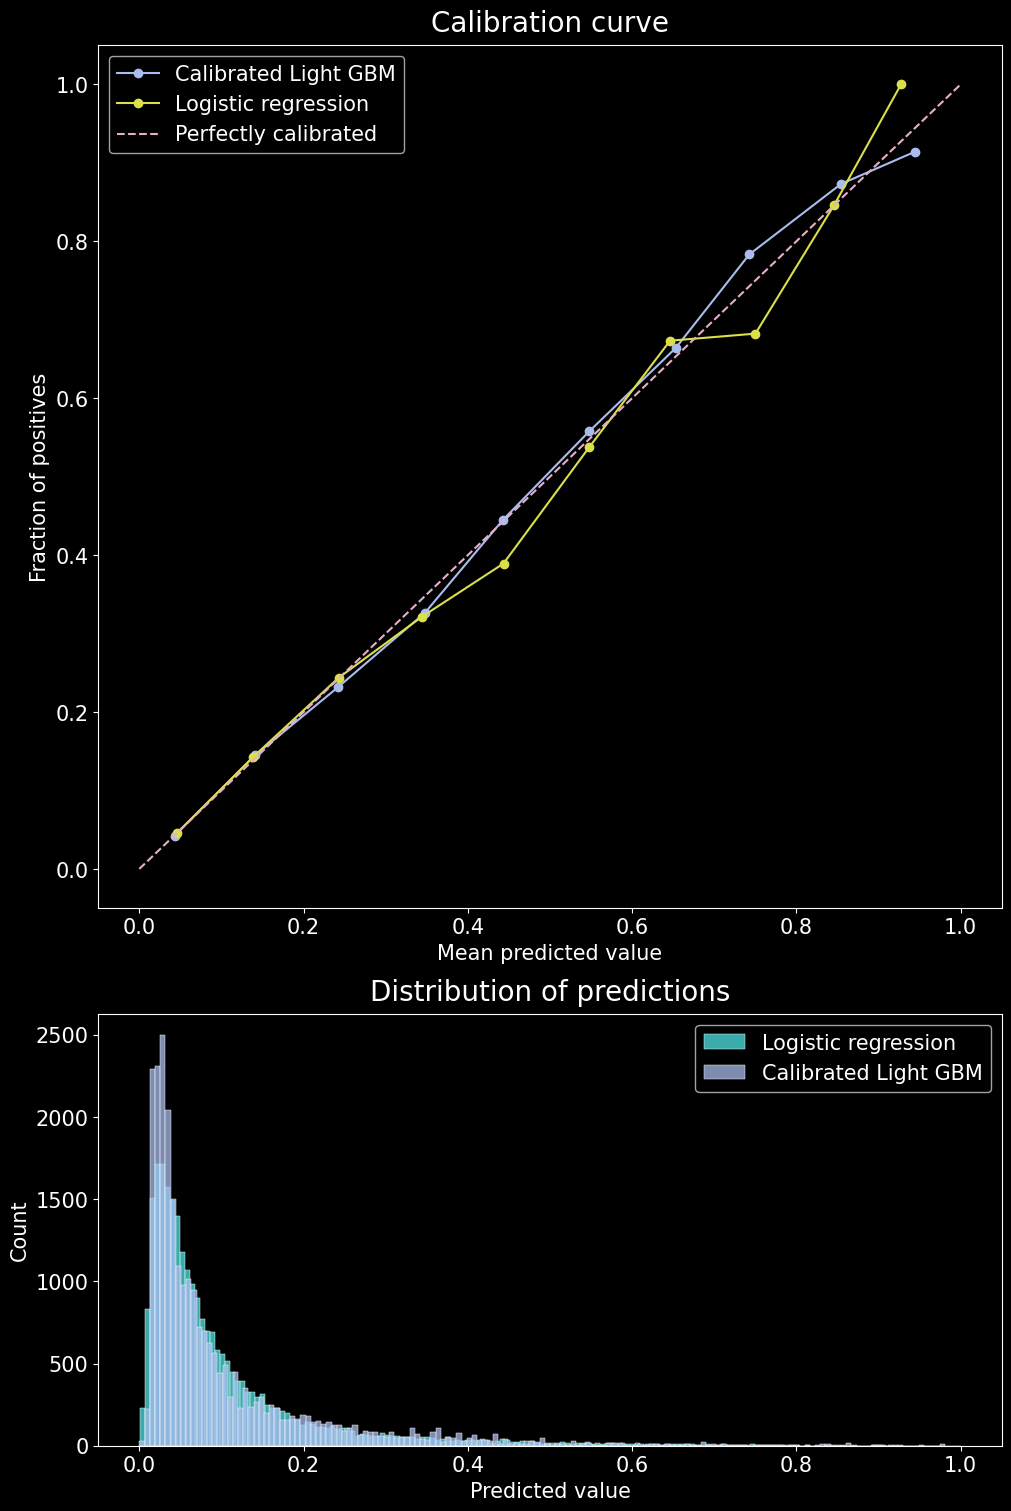

In [65]:
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.histplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.histplot(y_pred_lgbm_calibrated, color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join('..', 'figures', '22_calibration_curve.png'), bbox_inches = 'tight', pad_inches = 0.2)

From scikit-learn docs: "The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome."

In [66]:
print('Brier score, Light GBM:', brier_score_loss(y_test, y_pred_lgbm_calibrated, pos_label=y_test.max()))
print('ROC AUC, Light GBM:', roc_auc_score(y_test, y_pred_lgbm_calibrated))
print('Pseudo R-squared, Light GBM:', mcfadden_r2(y_test, y_pred_lgbm_calibrated))

Brier score, Light GBM: 0.07632107347669859
ROC AUC, Light GBM: 0.7989657631724563
ll: 0.2672360207600832, ll_null: 0.3286864952143405
ll: 0.2672360207600832, ll_null: 0.3286864952143405, r2: 0.1869577100032197
Pseudo R-squared, Light GBM: 0.1869577100032197


In [67]:
print('Brier score, logistic regression:',brier_score_loss(y_true_test, y_pred_lr, pos_label=y_true_test.max()))
print('ROC AUC, logistic regression:', roc_auc_score(y_true_test, y_pred_lr))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_true_test, y_pred_lr))

Brier score, logistic regression: 0.07842970986499088
ROC AUC, logistic regression: 0.7857369491473228
ll: 0.27435045400782493, ll_null: 0.3286864952143405
ll: 0.27435045400782493, ll_null: 0.3286864952143405, r2: 0.16531266723046345
Pseudo R-squared, logistic regression: 0.16531266723046345


# Save models

In [68]:
dump(searchcv.best_estimator_, os.path.join('..', 'models', 'lgbm_model.joblib'))

['..\\models\\lgbm_model.joblib']

In [69]:
dump(clf_pass.best_estimator_, os.path.join('..', 'models', 'lr_pass.joblib'))

['..\\models\\lr_pass.joblib']

In [70]:
dump(clf_other.best_estimator_, os.path.join('..', 'models', 'lr_other.joblib'))

['..\\models\\lr_other.joblib']

# Save data

In [71]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [72]:
X_train_other['goal'] = y_train_other
X_train_other['split'] = 'train'
X_test_other['goal'] = y_test_other
X_test_other['split'] = 'test'
df_other = pd.concat([X_train_other, X_test_other])
df_other = df_other.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join('..', 'data', 'modelling', 'lr_other.parquet'))

In [73]:
X_train_pass['goal'] = y_train_pass
X_train_pass['split'] = 'train'
X_test_pass['goal'] = y_test_pass
X_test_pass['split'] = 'test'
df_pass = pd.concat([X_train_pass, X_test_pass])
df_pass = df_pass.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join('..', 'data', 'modelling', 'lr_pass.parquet'))

In [74]:
X_train['goal'] = y_train
X_train['split'] = 'train'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train, X_test])
# exclude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df.index)].copy()
df_lgbm = df_lgbm.merge(df, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join('..', 'data', 'modelling', 'lgbm.parquet'))